## Weather Dataset

In [1]:
## https://www.kaggle.com/datasets/ananthr1/weather-prediction

## Import Libraries

In [2]:
import io, base64, os, json, re
from random import randint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime as dt

## alternative way of extracting data if datareader not work properly
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime

## Stock Data Analysis

### 1) Loading Stock Dataset

In [3]:
# data extraction from date: 2012-12-01 to 2022-12-01, 10 years in total
start_date = "2012-12-01"
end_date = "2022-12-01"

# choosing Tesla for prediction, ticker symbol: TSLA
symbol = "TSLA"
try: 
    tsla_stock = DataReader(name=symbol, data_source="yahoo", start=start_date, end=end_date)
except:
    tsla_stock = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)

# extract attributes 
tsla_stock = tsla_stock[["Open", "High", "Low", "Adj Close", "Volume"]]

[*********************100%***********************]  1 of 1 completed


In [4]:
tsla_stock.shape

(2517, 5)

### 2) calculating return and range 
1) **Return**: is the change in price of an asset over time, a positive return represents a profit while a negative return marks a loss. Here I used the close price from previous date minus today's price <br>
2) **Range**: the difference between the highest and lowest prices traded for a defined period (day, month or year). Here I used high minus low within a day

In [5]:
# add return and range attributes to the dataframe
df = tsla_stock.copy()

# per-share gain: (opening - clsoing price) * share amount
# precentage: opening/closing from previous day / closing price of today
df["Returns(%)"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1 # because latter - previous will cause the last row has no one to divide with, so exclude that row
df["Range(%)"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print(f"shape: {df.shape}")
df.head()

shape: (2516, 7)


,Open,High,Low,Adj Close,Volume,Returns(%),Range(%)
Date,,,,,,,
2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500,-0.020797,0.037258
2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500,-0.005605,0.018165
2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000,0.005636,0.038806
2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000,0.007965,0.018907
2012-12-10,2.295333,2.320000,2.278667,2.304667,13947000,0.011706,0.018139


In [6]:
df

,Open,High,Low,Adj Close,Volume,Returns(%),Range(%)
Date,,,,,,,
2012-12-04,2.272000,2.320000,2.236667,2.260000,18949500,-0.020797,0.037258
2012-12-05,2.254667,2.279333,2.238667,2.247333,9922500,-0.005605,0.018165
2012-12-06,2.254667,2.320000,2.233333,2.260000,9906000,0.005636,0.038806
2012-12-07,2.286667,2.299333,2.256667,2.278000,9966000,0.007965,0.018907
2012-12-10,2.295333,2.320000,2.278667,2.304667,13947000,0.011706,0.018139
...,...,...,...,...,...,...,...
2022-11-23,173.570007,183.619995,172.500000,183.199997,109536700,0.078218,0.064464
2022-11-25,185.059998,185.199997,180.630005,182.860001,50672700,-0.001856,0.025300
2022-11-28,179.960007,188.500000,179.000000,182.919998,92905200,0.000328,0.053073


### 3) Turn Date from index to attributes

In [7]:
# show all the columns, since Date is not listed as a column, so it should have been recongized as index
print(f"attributes: {df.columns}")
print()
print(f"index: {df.index}")

attributes: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Returns(%)', 'Range(%)'], dtype='object')

index: DatetimeIndex(['2012-12-04', '2012-12-05', '2012-12-06', '2012-12-07',
               '2012-12-10', '2012-12-11', '2012-12-12', '2012-12-13',
               '2012-12-14', '2012-12-17',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-25', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)


In [8]:
# reset index; and convert Data columns into datetime type
df.reset_index(inplace=True)
df["Date"]  = pd.to_datetime(df["Date"])
df.head(1)

,Date,Open,High,Low,Adj Close,Volume,Returns(%),Range(%)
0,2012-12-04,2.272,2.32,2.236667,2.26,18949500,-0.020797,0.037258


### 4) Randomize
**step 1. select a certain number of rows, calculating the percentage change between previous day and current day, form a new sub dataset with these new attributes** <br>
**step 2. using pandas built-in method -> pct_change(): (current_date - previous_date) / previous_date** <br>
**step 3. repeat this process for 100,000 times, and therefore will collect 100,000 sub dataset** <br>
**step 4. concatenate those 100,000 dataset as new huge dataset** <br> 

In [9]:
# randomize sequential rows from stock price (that will possibly cause certain pattern), collecting them into a list first
random_set = []

# for loop randomize
for i in range(0, 100000):
    
    nums_of_rows = randint(10, 100) # randomly select a certain number from 10 to 40 as the quantities of a sub dataset
    row_to_begin = randint(0, len(df) - nums_of_rows) # randomly select a row to begin with as forming the sub dataset
    sub_dataset = df.iloc[row_to_begin : row_to_begin + nums_of_rows]
    
    # select the last date in each subset as an indicator for predicting 
    Close_Date = max(sub_dataset["Date"])
    
    # forming the new dataset with new attributes 
    Close_Change = sub_dataset["Adj Close"].pct_change()
    High_Change = sub_dataset["High"].pct_change() 
    Low_Change = sub_dataset["Low"].pct_change() 
    Volume_Change = sub_dataset["Volume"].pct_change() 
    Return_Change = sub_dataset["Returns(%)"].pct_change()
    
    Daily_Change = (sub_dataset["Adj Close"] - sub_dataset["Open"]) / sub_dataset["Open"]
    Next_Day_Volume_Tendency = (sub_dataset["Volume"].shift(-1) - sub_dataset["Volume"]) # use volume as prediction 
    Next_Day_Return_Tendency = (sub_dataset["Returns(%)"].shift(-1) - sub_dataset["Returns(%)"]) # use return as prediction
    
    random_set.append(pd.DataFrame({'Sequence_ID': [nums_of_rows] * len(sub_dataset),
                                    'Close_Date': [Close_Date]*len(sub_dataset),
                                    'Close_Change': Close_Change,
                                    'High_Change': High_Change,
                                    'Low_Change': Low_Change,
                                    'Volume_Change': Volume_Change, 
                                    'Daily_Change': Daily_Change,
                                    'Next_Day_Volume_Outcome': Next_Day_Volume_Tendency,
                                    'Next_Day_Return_Outcome': Next_Day_Return_Tendency}))
    
# ===================================================================================================
# concatenate random_set 
tsla_df = pd.concat(random_set)
print(f'the shape of new dataset before dropping NaN rows: {tsla_df.shape}')

# drop rows with NaN value 
tsla_df = tsla_df.dropna(how='any')
print(f'the shape of new dataset after dropping NaN rows: {tsla_df.shape}')

# display newly concatenated  dataset
tsla_df.head(20)

the shape of new dataset before dropping NaN rows: (5493819, 9)
the shape of new dataset after dropping NaN rows: (5293819, 9)


,Sequence_ID,Close_Date,Close_Change,High_Change,Low_Change,Volume_Change,Daily_Change,Next_Day_Volume_Outcome,Next_Day_Return_Outcome
1940,79,2020-12-08,-0.004536,-0.006705,-0.002114,-0.259140,0.007255,126097500.0,0.070172
1941,79,2020-12-08,0.065636,0.058080,0.008609,0.688758,0.075859,13167000.0,-0.041584
1942,79,2020-12-08,0.024053,0.036350,0.090460,0.042587,0.002553,-21390000.0,-0.041507
1943,79,2020-12-08,-0.017454,0.015992,-0.048162,-0.066358,-0.052712,-141070500.0,0.021992
1944,79,2020-12-08,0.004538,-0.047464,0.021001,-0.468744,0.024533,53707500.0,0.059628
1945,79,2020-12-08,0.064166,0.068074,0.043511,0.335916,0.045228,141804000.0,-0.024420
1946,79,2020-12-08,0.039746,0.059834,0.043275,0.663904,0.026733,-54177000.0,-0.051069
1947,79,2020-12-08,-0.011323,0.009971,0.020546,-0.152442,-0.035606,53905200.0,0.137012
1948,79,2020-12-08,0.125689,0.078590,0.006417,0.178957,0.120803,-85599900.0,-0.172386
1949,79,2020-12-08,-0.046697,0.004699,0.069074,-0.241043,-0.053949,19005000.0,-0.011571


### 5) Plotting Attributes
**Daily Change** <br>
**Close Change** <br>
**Volume Chnage** <br>
**Return Chnage** <br>

array([[<AxesSubplot: title={'center': 'Close_Change'}>]], dtype=object)

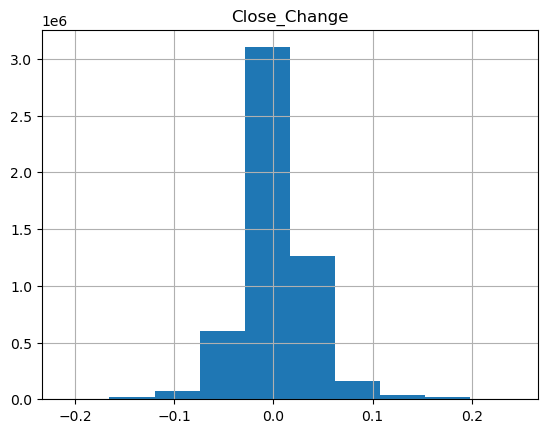

In [10]:
# histogram
tsla_df.hist(column='Close_Change')

array([[<AxesSubplot: title={'center': 'Volume_Change'}>]], dtype=object)

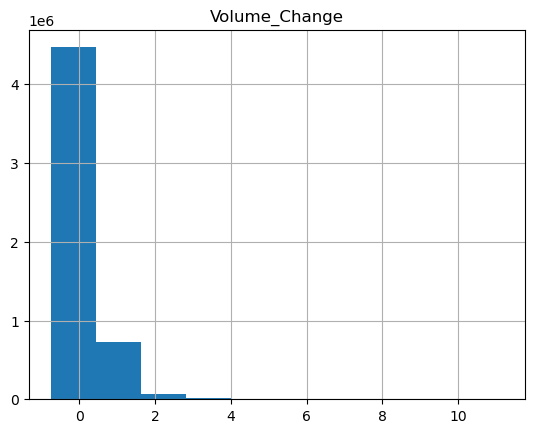

In [11]:
# histogram
tsla_df.hist(column='Volume_Change')

array([[<AxesSubplot: title={'center': 'Daily_Change'}>]], dtype=object)

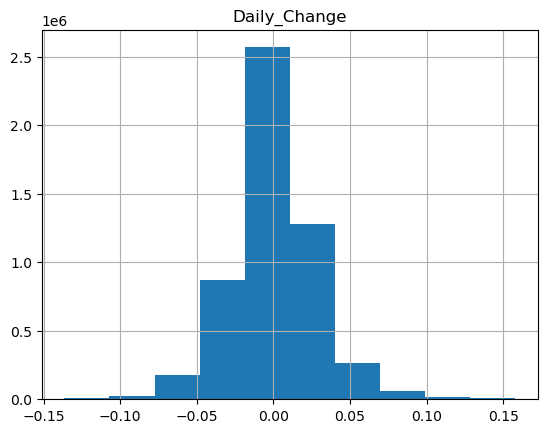

In [12]:
# histogram
tsla_df.hist(column='Daily_Change')

### 6) Categoricalize the numeric data
**step 1. binning data in each attributes with equal frequency, assign them with labels as the following "L", "M", "H", where "L" means low, "M" means middle, "H" means high** <br>
**step 2. label attributes in each rows as an event pattern, as X; excluding Next_Day_Volume_Outcome and Next_Day_Return_Outcome as Y for prediction** <br>
**step 3. group event pattern for the same date**

In [13]:
# make a copy of the numeric dataset 
tsla_sample = tsla_df.copy()

# create sequences
# simplify the data by binning values into three groups
 
# Close_Change
tsla_sample['Close_Change_Tag'] = pd.qcut(tsla_sample['Close_Change'], 3, labels=["L", "M", "H"])

# High_Change (not used)
tsla_sample['High_Change_Tag'] = pd.qcut(tsla_sample['High_Change'], 3, labels=["L", "M", "H"])

# Low_Change (not used)
tsla_sample['Low_Change_Tag'] = pd.qcut(tsla_sample['Low_Change'], 3, labels=["L", "M", "H"])

# Volume_Change
tsla_sample['Volume_Change_Tag'] = pd.qcut(tsla_sample['Volume_Change'], 3, labels=["L", "M", "H"])
 
# Daily_Change
tsla_sample['Daily_Change_Tag'] = pd.qcut(tsla_sample['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
tsla_sample = tsla_sample[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Change_Tag", 
                         "Volume_Change_Tag", 
                         "Daily_Change_Tag", 
                         "Next_Day_Volume_Outcome",
                          "Next_Day_Return_Outcome"]]

tsla_sample['Event_Pattern'] = tsla_sample['Close_Change_Tag'].astype(str) + tsla_sample['Volume_Change_Tag'].astype(str) + tsla_sample['Daily_Change_Tag'].astype(str)

# check volume outcome
print(f'volume outcome: \n===================== \n{tsla_sample["Next_Day_Volume_Outcome"].describe()}')
print()
# check return outcome
print(f'return outcome: \n===================== \n{tsla_sample["Next_Day_Return_Outcome"].describe()}')

# display dataset
tsla_sample.head()

volume outcome: 
count    5.293819e+06
mean     2.045279e+04
std      5.857310e+07
min     -4.922427e+08
25%     -2.196150e+07
50%     -2.368500e+06
75%      1.887900e+07
max      4.975683e+08
Name: Next_Day_Volume_Outcome, dtype: float64

return outcome: 
count    5.293819e+06
mean    -6.396954e-06
std      5.096068e-02
min     -3.090148e-01
25%     -2.735964e-02
50%     -6.072637e-04
75%      2.602979e-02
max      3.442209e-01
Name: Next_Day_Return_Outcome, dtype: float64


,Sequence_ID,Close_Date,Close_Change_Tag,Volume_Change_Tag,Daily_Change_Tag,Next_Day_Volume_Outcome,Next_Day_Return_Outcome,Event_Pattern
1940,79,2020-12-08,M,L,M,126097500.0,0.070172,MLM
1941,79,2020-12-08,H,H,H,13167000.0,-0.041584,HHH
1942,79,2020-12-08,H,M,M,-21390000.0,-0.041507,HMM
1943,79,2020-12-08,L,M,L,-141070500.0,0.021992,LML
1944,79,2020-12-08,M,L,H,53707500.0,0.059628,MLH


### 7) Grouping Data
**event pattern**: grouping pattern for the same day {MMM, MHM, LML, ..., etc} <br>
**outcome mean**: (aggregated all outcome) / quantities

In [14]:
# groupby function will apply self defined function to all columns
pattern_df = tsla_sample.groupby(['Sequence_ID', 
                                     'Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(tsla_sample.shape)
pattern_df.head() 

(5293819, 8)


,Sequence_ID,Close_Date,Event_Pattern
0,10,2012-12-18,"{MMM, MMM, MHM, HHH, MHM, LML, MLM, HLH}"
1,10,2012-12-19,"{MMM, MHM, HHH, MHM, LML, MLM, HLH, MHH}"
2,10,2012-12-27,"{MLM, HLH, MHH, MLM, MLM, LHM, MLH, LHL, MLM, ..."
3,10,2012-12-28,"{HLH, MHH, MLM, MLM, LHM, MLH, LHL, MMM}"
4,10,2013-01-08,"{LHL, MMM, LLM, HHH, HHH, LLL, LML, MLL}"


In [15]:
# calculating mean outcome using volume and return
volume_outcome = tsla_sample.groupby(['Sequence_ID', 'Close_Date'])['Next_Day_Volume_Outcome'].mean()
volume_outcome = volume_outcome.to_frame().reset_index()
return_outcome = tsla_sample.groupby(['Sequence_ID', 'Close_Date'])['Next_Day_Return_Outcome'].mean()
return_outcome = return_outcome.to_frame().reset_index()

# describe dataset
# outcomes were shrinked to 56084 rows
print("============= volume properties =============")
print(volume_outcome.shape)
print(volume_outcome.describe())
print()
print("============= return properties =============")
print(return_outcome.shape)
print(return_outcome.describe())

============= volume properties =============
(80494, 3)
        Sequence_ID  Next_Day_Volume_Outcome
count  80494.000000             8.049400e+04
mean      54.870202             3.012603e+04
std       26.207225             3.251942e+06
min       10.000000            -8.483456e+07
25%       32.000000            -7.487647e+05
50%       55.000000             4.848777e+01
75%       77.000000             7.581306e+05
max      100.000000             7.741462e+07

============= return properties =============
(80494, 3)
        Sequence_ID  Next_Day_Return_Outcome
count  80494.000000             80494.000000
mean      54.870202                -0.000007
std       26.207225                 0.001847
min       10.000000                -0.028674
25%       32.000000                -0.000548
50%       55.000000                 0.000002
75%       77.000000                 0.000541
max      100.000000                 0.034625


In [16]:
# merge with volume
volume_set = pd.merge(pattern_df, volume_outcome, on= ['Sequence_ID', 'Close_Date'], how='inner')
# merge with return
return_set = pd.merge(pattern_df, return_outcome, on= ['Sequence_ID', 'Close_Date'], how='inner')

# =================================================================================
# eliminate the bracket from volume and return Event_Pattern
volume_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in volume_set['Event_Pattern'].values]

return_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in return_set['Event_Pattern'].values]

In [17]:
# display volume_set and return_set
volume_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Next_Day_Volume_Outcome
0,10,2012-12-18,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH",1675312.5
1,10,2012-12-19,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",1189500.0
2,10,2012-12-27,"MLM,HLH,MHH,MLM,MLM,LHM,MLH,LHL,MLM,HLH,MHH,ML...",-866062.5
3,10,2012-12-28,"HLH,MHH,MLM,MLM,LHM,MLH,LHL,MMM",-770250.0
4,10,2013-01-08,"LHL,MMM,LLM,HHH,HHH,LLL,LML,MLL",1279875.0


In [18]:
return_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Next_Day_Return_Outcome
0,10,2012-12-18,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH",-0.000014
1,10,2012-12-19,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",-0.000923
2,10,2012-12-27,"MLM,HLH,MHH,MLM,MLM,LHM,MLH,LHL,MLM,HLH,MHH,ML...",-0.000372
3,10,2012-12-28,"HLH,MHH,MLM,MLM,LHM,MLH,LHL,MMM",-0.003925
4,10,2013-01-08,"LHL,MMM,LLM,HHH,HHH,LLL,LML,MLL",0.000114


### 8) Building Training and Testing set

In [19]:
# first date to 90 days before current date for test set 
train_volume = volume_set[volume_set['Close_Date'] < dt.datetime.now() 
                                           - dt.timedelta(days=90)]  
# use last x days of data for validation, test for volume first. Use last 90 days for validation
test_volume = volume_set[volume_set['Close_Date'] >= dt.datetime.now() 
                                           - dt.timedelta(days=90)] # current - 90 days: last 90 days

# ==========================================================================
# first date to 90 days before current date for test set 
train_return = return_set[return_set['Close_Date'] < dt.datetime.now()
                                        - dt.timedelta(days=90)]
test_return = return_set[return_set['Close_Date'] >= dt.datetime.now() 
                                        - dt.timedelta(days=90)]

In [20]:
# drop volume data attributes
train_volume = train_volume.drop(columns=['Close_Date'])
test_volume = test_volume.drop(columns=['Close_Date'])

# drop return data attributes
train_return = train_return.drop(columns=['Close_Date'])
test_return = test_return.drop(columns=['Close_Date'])

In [21]:
train_volume

,Sequence_ID,Event_Pattern,Next_Day_Volume_Outcome
0,10,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH",1.675312e+06
1,10,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",1.189500e+06
2,10,"MLM,HLH,MHH,MLM,MLM,LHM,MLH,LHL,MLM,HLH,MHH,ML...",-8.660625e+05
3,10,"HLH,MHH,MLM,MLM,LHM,MLH,LHL,MMM",-7.702500e+05
4,10,"LHL,MMM,LLM,HHH,HHH,LLL,LML,MLL",1.279875e+06
...,...,...,...
80473,100,"LHL,MLL,MHL,MLL,HMH,MLM,HHH,LHL,LLL,LHL,HML,LH...",-7.279408e+05
80474,100,"MHL,MLL,HMH,MLM,HHH,LHL,LLL,LHL,HML,LHL,LHH,HL...",-6.603806e+05
80475,100,"MLL,HMH,MLM,HHH,LHL,LLL,LHL,HML,LHL,LHH,HLM,LM...",-2.703092e+05
80476,100,"MLM,HHH,LHL,LLL,LHL,HML,LHL,LHH,HLM,LML,HMH,LM...",6.975408e+04


In [22]:
train_return

,Sequence_ID,Event_Pattern,Next_Day_Return_Outcome
0,10,"MMM,MMM,MHM,HHH,MHM,LML,MLM,HLH",-0.000014
1,10,"MMM,MHM,HHH,MHM,LML,MLM,HLH,MHH",-0.000923
2,10,"MLM,HLH,MHH,MLM,MLM,LHM,MLH,LHL,MLM,HLH,MHH,ML...",-0.000372
3,10,"HLH,MHH,MLM,MLM,LHM,MLH,LHL,MMM",-0.003925
4,10,"LHL,MMM,LLM,HHH,HHH,LLL,LML,MLL",0.000114
...,...,...,...
80473,100,"LHL,MLL,MHL,MLL,HMH,MLM,HHH,LHL,LLL,LHL,HML,LH...",0.001282
80474,100,"MHL,MLL,HMH,MLM,HHH,LHL,LLL,LHL,HML,LHL,LHH,HL...",0.000239
80475,100,"MLL,HMH,MLM,HHH,LHL,LLL,LHL,HML,LHL,LHH,HLM,LM...",0.000067
80476,100,"MLM,HHH,LHL,LLL,LHL,HML,LHL,LHH,HLM,LML,HMH,LM...",-0.000486


### 9) Keep only big change record

In [23]:
train_volume['Next_Day_Volume_Outcome'].describe()

count    7.893300e+04
mean     2.635248e+04
std      3.281078e+06
min     -8.483456e+07
25%     -7.647000e+05
50%     -2.282609e+03
75%      7.628294e+05
max      7.741462e+07
Name: Next_Day_Volume_Outcome, dtype: float64

In [24]:
train_return['Next_Day_Return_Outcome'].describe()

count    78933.000000
mean        -0.000006
std          0.001845
min         -0.028674
25%         -0.000542
50%          0.000004
75%          0.000540
max          0.034625
Name: Next_Day_Return_Outcome, dtype: float64

In [25]:
import warnings
warnings.filterwarnings("ignore")

# keep only keep big/interesting change in volume for test set
print('all moves from volume:', len(train_volume))
volume_train_set = train_volume[abs(train_volume['Next_Day_Volume_Outcome']) > 1000000] # because std is 10^6
volume_train_set['Next_Day_Volume_Outcome'] = np.where((volume_train_set['Next_Day_Volume_Outcome'] > 0), 1, 0)

# for test set
volume_test_set = test_volume.copy()
volume_test_set['Next_Day_Volume_Outcome'] = np.where((volume_test_set['Next_Day_Volume_Outcome'] > 0), 1, 0)
print('big moves only from volume:', len(volume_train_set)) 

print()
print("==================================")
print()

# for return training
print('all moves from return:', len(train_return))
return_train_set = train_return[abs(train_return['Next_Day_Return_Outcome']) > 0.001] # because std is 10^6
return_train_set['Next_Day_Return_Outcome'] = np.where((return_train_set['Next_Day_Return_Outcome'] > 0), 1, 0)

# for return test set
return_test_set = test_return.copy()
return_test_set['Next_Day_Return_Outcome'] = np.where((return_test_set['Next_Day_Return_Outcome'] > 0), 1, 0)
print('big moves only from return:', len(return_train_set)) 

all moves from volume: 78933
big moves only from volume: 32871


all moves from return: 78933
big moves only from return: 23326


In [26]:
# find unique pattern = remove duplicate patterns and only collect those unique one
# volume set
volume_list = [item.split(',') for item in volume_train_set['Event_Pattern'].values ]
volume_patterns = ','.join(str(r) for v in volume_list for r in v)
volume_patterns = list(set(volume_patterns.split(',')))
print(f"unique patterns from volume set: {len(volume_patterns)}")

# return set
return_list = [item.split(',') for item in return_train_set['Event_Pattern'].values ]
return_patterns = ','.join(str(r) for v in return_list for r in v)
return_patterns = list(set(return_patterns.split(',')))
print(f"unique patterns from return set: {len(return_patterns)}")

print()
print("============================")
print()
# ============ create positive and negative dataset ================
# for volume
volume_train_pos = volume_train_set[volume_train_set['Next_Day_Volume_Outcome']==1][['Sequence_ID', 'Event_Pattern']]
print(f"positive set for volume training data: {volume_train_pos.shape}")
volume_train_neg = volume_train_set[volume_train_set['Next_Day_Volume_Outcome']==0][['Sequence_ID', 'Event_Pattern']]
print(f"negative set for volume training data: {volume_train_neg.shape}")

# for return
return_train_pos = return_train_set[return_train_set['Next_Day_Return_Outcome']==1][['Sequence_ID', 'Event_Pattern']]
print(f"positive set for return training data: {volume_train_pos.shape}")
return_train_neg = return_train_set[return_train_set['Next_Day_Return_Outcome']==0][['Sequence_ID', 'Event_Pattern']]
print(f"negative set for return training data: {volume_train_neg.shape}")

unique patterns from volume set: 27
unique patterns from return set: 27


positive set for volume training data: (16493, 2)
negative set for volume training data: (16378, 2)
positive set for return training data: (16493, 2)
negative set for return training data: (16378, 2)


### 10) Build Markov Transition Matrix (grid)

In [27]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # loop from unique pattern, starting with something like this: MMM, HLH

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)] # count the occurence in both positive and negative matrix of each pattern combination
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})

    grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    #del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)

In [28]:
# a first-ordered matrix will be built, meaning row attributes will follow the same order as the order of the column attributes
# for volume
volume_grid_pos = build_transition_grid(volume_train_pos, volume_patterns) 
volume_grid_neg = build_transition_grid(volume_train_neg, volume_patterns) 

# for return
return_grid_pos = build_transition_grid(return_train_pos, return_patterns) 
return_grid_neg = build_transition_grid(return_train_neg, return_patterns) 

In [29]:
volume_grid_pos

,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MML,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.144165,0.046047,0.177430,0.111707,0.391342,0.125254,0.086953,0.355632,0.305771,0.106330,...,0.012261,0.033341,0.076685,0.077117,0.188705,0.191037,0.155083,0.204647,0.172549,0.107215
HHL,0.010536,0.000000,0.000034,0.007353,0.000000,0.016340,0.026852,0.000133,0.000120,0.000000,...,0.000000,0.000000,0.000000,0.000053,0.000175,0.022819,0.019422,0.000094,0.000179,0.000075
HHM,0.024379,0.040521,0.000236,0.056745,0.000437,0.093655,0.037021,0.102673,0.000060,0.000000,...,0.000187,0.089919,0.000270,0.099226,0.059711,0.042996,0.053028,0.014661,0.123266,0.005942
HLH,0.071476,0.284831,0.083936,0.013499,0.000000,0.019392,0.052030,0.056789,0.038755,0.000000,...,0.056252,0.216322,0.155256,0.015792,0.063382,0.143191,0.056763,0.080894,0.127373,0.094861
HLL,0.000008,0.000000,0.000000,0.006406,0.000000,0.036559,0.010068,0.000000,0.000000,0.047196,...,0.000000,0.000000,0.000000,0.000053,0.000044,0.008530,0.000031,0.003466,0.000000,0.000038
HLM,0.022641,0.000000,0.012666,0.022319,0.000000,0.017930,0.038713,0.000133,0.000301,0.028595,...,0.000094,0.000112,0.000000,0.000053,0.000131,0.000130,0.021960,0.009649,0.035415,0.035425
HMH,0.062425,0.000132,0.108188,0.049336,0.064276,0.061673,0.080134,0.039500,0.089968,0.000000,...,0.052883,0.000337,0.001752,0.081644,0.064781,0.030483,0.071857,0.096773,0.036248,0.115563
HML,0.000051,0.000000,0.012734,0.000037,0.000000,0.000000,0.000017,0.000000,0.000060,0.000000,...,0.000281,0.097777,0.000000,0.000053,0.000044,0.034510,0.000072,0.000000,0.000000,0.000113
HMM,0.029384,0.000000,0.007397,0.000613,0.000000,0.040374,0.010710,0.115707,0.000060,0.000000,...,0.000187,0.000000,0.000135,0.000000,0.014950,0.000260,0.006263,0.022015,0.098149,0.017562


In [30]:
volume_test_set.head()

,Sequence_ID,Event_Pattern,Next_Day_Volume_Outcome
856,10,"HLH,MMM,LML,LML,LML,MMH,HMM,HMH",1
857,10,"MMM,LML,LML,LML,MMH,HMM,HMH,LHL",1
858,10,"LML,LML,MMH,HMM,HMH,LHL,LMM,LHL",1
859,10,"LML,MMH,HMM,HMH,LHL,LMM,LHL,HMM,LML,MMH,HMM,HM...",1
860,10,"HMH,LHL,LMM,LHL,HMM,LLL,LLM,LHL",1


### 11) Prediction for Volume

In [31]:
# prediction on the training dataset
actual = []
predicted = []

temp_id = 12345
# outter loop start: a sequence for validation {"HMM", "LHL", "MLM", "HHH", "LLL"}
for seq_id in volume_test_set['Sequence_ID'].values:
    if temp_id != seq_id:
        count = 0
    temp_id = seq_id

    patterns = volume_test_set[volume_test_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[count].split(',')
    pos = []
    neg = []
    log_odds = []
    
    # inner loop start: calculating the patterns from one to one, and reach the end 
    for id in range(0, len(patterns)-1):
#         print(f"this is the {count} time")
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        
        # check if the first pair is both in pos and neg matrix
        if (patterns[id] in list(volume_grid_pos) and patterns[id+1] in list(volume_grid_pos) and patterns[id] in list(volume_grid_neg) and patterns[id+1] in list(volume_grid_neg)):
                
            # if they are in, build the probability of the pair: positive as numerator, negative as denominator
            numerator = volume_grid_pos[patterns[id]][patterns[id+1]]
            denominator = volume_grid_neg[patterns[id]][patterns[id+1]]
            
            # if they both == 0, meaning this patterns doesn't contain in the pre-built matrix, so the log value = 0
            if (numerator == 0 and denominator == 0):
                log_value =0
            
            # if negative matrix == 0, means the patterns doesn't exist in the neg matrix, 
            # we perform calculation on the positive one
            elif (denominator == 0):
                
                # why do we need log calculation? because when we keep times the coming value from the matrix without any modification,
                # we will result in very small probability for any event given a relatively long sequences of pattern, if that's the true possibility, then it's not practical in real life,
                # on the other hand, large number will require more calculation power, we want to reduce that
                # divided by 0.000001 is just make this log value into positive
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                
                # 0.000001 divide denominator is just make the log value into negative 
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0

        
        # append all log values, because we want to see it's either positive or negative it's enough
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
        # inner loop ends

    actual.append(volume_test_set[volume_test_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    predicted.append(sum(log_odds))
    # outter loop end
    count += 1

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

array([[933, 167],
       [320, 141]])

In [33]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 68.8 %


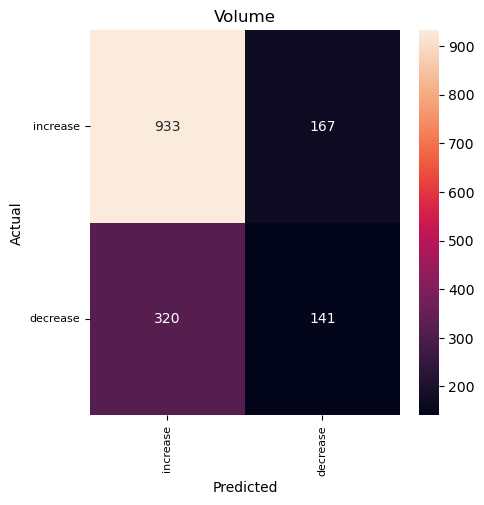

In [34]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Volume') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['increase','decrease'])
ax.yaxis.set_ticklabels(['increase','decrease'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

### 12) Prediction for return

In [35]:
# prediction on the training dataset
actual = []
predicted = []

temp_id = 12345
# outter loop start: a sequence for validation {"HMM", "LHL", "MLM", "HHH", "LLL"}
for seq_id in volume_test_set['Sequence_ID'].values:
    if temp_id != seq_id:
        count = 0
    temp_id = seq_id

    patterns = volume_test_set[volume_test_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[count].split(',')
    pos = []
    neg = []
    log_odds = []
    
    # inner loop start: calculating the patterns from one to one, and reach the end 
    for id in range(0, len(patterns)-1):
#         print(f"this is the {count} time")
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        
        # check if the first pair is both in pos and neg matrix
        if (patterns[id] in list(volume_grid_pos) and patterns[id+1] in list(volume_grid_pos) and patterns[id] in list(volume_grid_neg) and patterns[id+1] in list(volume_grid_neg)):
                
            # if they are in, build the probability of the pair: positive as numerator, negative as denominator
            numerator = volume_grid_pos[patterns[id]][patterns[id+1]]
            denominator = volume_grid_neg[patterns[id]][patterns[id+1]]
            
            # if they both == 0, meaning this patterns doesn't contain in the pre-built matrix, so the log value = 0
            if (numerator == 0 and denominator == 0):
                log_value =0
            
            # if negative matrix == 0, means the patterns doesn't exist in the neg matrix, 
            # we perform calculation on the positive one
            elif (denominator == 0):
                
                # why do we need log calculation? because when we keep times the coming value from the matrix without any modification,
                # we will result in very small probability for any event given a relatively long sequences of pattern, if that's the true possibility, then it's not practical in real life,
                # on the other hand, large number will require more calculation power, we want to reduce that
                # divided by 0.000001 is just make this log value into positive
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                
                # 0.000001 divide denominator is just make the log value into negative 
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0

        
        # append all log values, because we want to see it's either positive or negative it's enough
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
        # inner loop ends

    actual.append(volume_test_set[volume_test_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    predicted.append(sum(log_odds))
    # outter loop end
    count += 1

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

array([[933, 167],
       [320, 141]])

In [37]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 68.8 %


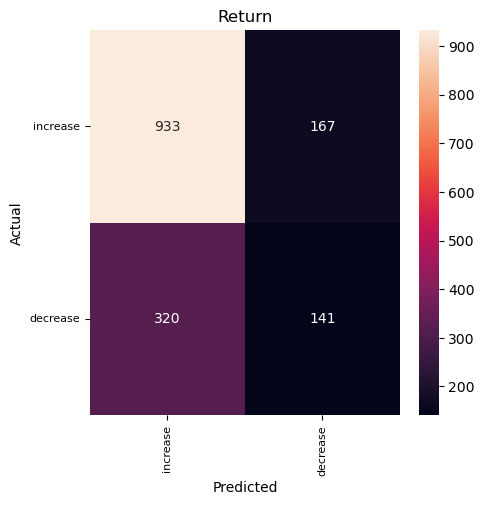

In [38]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Return') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['increase','decrease'])
ax.yaxis.set_ticklabels(['increase','decrease'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

## Weather Data Analysis

### 1) Load Dataset

In [39]:
# load .csv data 
df = pd.read_csv("./dataset/seattle-weather.csv")

In [40]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [41]:
df.shape

(1461, 6)

In [42]:
df.weather.unique()

array(['drizzle', 'rain', 'sun', 'snow', 'fog'], dtype=object)

### 2) generate random dataset with pct_change()

In [43]:
# generating random dataset 
random_set_withPCT = []

# for loop randomize
for i in range(0, 50000):
    
    nums_of_rows = randint(10, 90) # randomly select a certain number from 10 to 40 as the quantities of a sub dataset
    row_to_begin = randint(0, len(df) - nums_of_rows) # randomly select a row to begin with as forming the sub dataset
    sub_dataset = df.iloc[row_to_begin : row_to_begin + nums_of_rows]
    
    Test_Date = max(sub_dataset["date"])
    
    Precipitation_Change = sub_dataset["precipitation"].pct_change()
    TempMax_Change = sub_dataset["temp_max"].pct_change() 
    TempMin_Change = sub_dataset["temp_min"].pct_change() 
    Wind_Change = sub_dataset["wind"].pct_change() 
    Weather = sub_dataset["weather"]
    
    random_set_withPCT.append(pd.DataFrame({'Sequence_ID': [nums_of_rows] * len(sub_dataset),
                                    'Test_Date': Test_Date,
                                    'Precipitation_Change': Precipitation_Change,
                                    'TempMax_Change': TempMax_Change,
                                    'TempMin_Change': TempMin_Change,
                                    'Wind_Change': Wind_Change, 
                                    'Weather': Weather}))

In [44]:
# concatenate random_set 
weather_df_withPCT= pd.concat(random_set_withPCT)
print(f'the shape of new dataset before dropping NaN rows: {weather_df_withPCT.shape}')


# Replace infinite updated data with nan
weather_df_withPCT.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop rows with NaN value 
weather_df_withPCT = weather_df_withPCT.dropna(how='any')
print(f'the shape of new dataset after dropping NaN rows: {weather_df_withPCT.shape}')

# display the some data
weather_df_withPCT.tail(20)

the shape of new dataset before dropping NaN rows: (2506298, 7)
the shape of new dataset after dropping NaN rows: (1011396, 7)


,Sequence_ID,Test_Date,Precipitation_Change,TempMax_Change,TempMin_Change,Wind_Change,Weather
97,36,2012-05-02,-1.000000,0.450450,-0.484848,0.653846,sun
102,36,2012-05-02,-0.782609,0.252252,-0.222222,0.000000,rain
103,36,2012-05-02,-1.000000,0.079137,-0.303571,0.538462,drizzle
107,36,2012-05-02,-0.777778,-0.248120,-0.343284,-0.655172,rain
108,36,2012-05-02,0.000000,0.330000,0.636364,0.950000,rain
109,36,2012-05-02,5.055556,0.045113,-0.305556,-0.333333,rain
110,36,2012-05-02,-0.394495,-0.043165,0.340000,0.038462,rain
111,36,2012-05-02,-1.000000,0.503759,-0.343284,-0.148148,sun
115,36,2012-05-02,1.488372,0.201439,-0.110000,-0.071429,rain
116,36,2012-05-02,-0.644860,-0.167665,-0.247191,1.000000,rain


In [45]:
# make a copy 
w_df_withPCT = weather_df_withPCT.copy()

# build new dataset with pattern
# Precipitation: P for high, p for low
# TempMax: T-X for high, t-x for low
# TempMin: T-N for high, t-n for low
# Wind: W for high, w for low
w_df_withPCT["Precipitation_Tag"] = pd.qcut(w_df_withPCT["Precipitation_Change"], 2, labels=["P", "p"])

w_df_withPCT["TempMax_Tag"] = pd.qcut(w_df_withPCT["TempMax_Change"], 2, labels=["T", "t"])

w_df_withPCT["TempMin_Tag"] = pd.qcut(w_df_withPCT["TempMin_Change"], 2, labels=["M", "m"])

w_df_withPCT["Wind_Tag"] = pd.qcut(w_df_withPCT["Wind_Change"], 2, labels=["W", "w"])

# new set
new_w_withPCT = w_df_withPCT[["Sequence_ID",
             "Test_Date",
             "Precipitation_Tag",
             "TempMax_Tag",
             "TempMin_Tag", 
             "Wind_Tag",
             "Weather"]]

new_w_withPCT['Event_Pattern'] = new_w_withPCT['Precipitation_Tag'].astype(str)+new_w_withPCT['TempMax_Tag'].astype(str)+new_w_withPCT['TempMin_Tag'].astype(str)+new_w_withPCT['Wind_Tag'].astype(str)

In [46]:
print(f"shape: {new_w_withPCT.shape}")
new_w_withPCT.head(10)

shape: (1011396, 8)


,Sequence_ID,Test_Date,Precipitation_Tag,TempMax_Tag,TempMin_Tag,Wind_Tag,Weather,Event_Pattern
369,27,2013-01-25,p,t,M,W,rain,ptMW
370,27,2013-01-25,p,T,m,w,rain,pTmw
371,27,2013-01-25,p,t,M,W,rain,ptMW
372,27,2013-01-25,p,t,m,w,rain,ptmw
373,27,2013-01-25,p,t,m,W,rain,ptmW
374,27,2013-01-25,p,T,M,W,rain,pTMW
375,27,2013-01-25,P,T,M,W,snow,PTMW
376,27,2013-01-25,P,T,m,W,drizzle,PTmW
389,27,2013-01-25,p,T,M,W,rain,pTMW
390,27,2013-01-25,p,t,m,W,rain,ptmW


### 3) generate random dataset without pct_change()

#### without using PCT(), it will let the data contain some duplicates in each columns, because I didn't do any operation on them, they stay the same one method to do is slightly minus - 0.001 to change the value, so then the calculation can be perform, and the value that need to minus should depends on all the value distribution in that column

In [47]:
# generating random dataset 
random_set_2 = []

# for loop randomize
for i in range(0, 10000):
    
    nums_of_rows = randint(10, 90) # randomly select a certain number from 10 to 40 as the quantities of a sub dataset
    row_to_begin = randint(0, len(df) - nums_of_rows) # randomly select a row to begin with as forming the sub dataset
    sub_dataset = df.iloc[row_to_begin : row_to_begin + nums_of_rows]
    
    # select the last date in each subset as an indicator for predicting 
    Test_Date = max(sub_dataset["date"])

    Precipitation = sub_dataset["precipitation"]
    TempMax = sub_dataset["temp_max"]
    TempMin = sub_dataset["temp_min"]
    Wind = sub_dataset["wind"]
    Weather = sub_dataset["weather"]
    
    random_set_2.append(pd.DataFrame({'Sequence_ID': [nums_of_rows] * len(sub_dataset),
                                    'Test_Date': Test_Date,
                                    'Precipitation': Precipitation,
                                    'TempMax': TempMax,
                                    'TempMin': TempMin,
                                    'Wind': Wind, 
                                    'Weather': Weather}))

In [48]:
# concatenate random_set 
weather_df = pd.concat(random_set_2)
print(f'the shape of new dataset before dropping NaN rows: {weather_df.shape}')

# drop rows with NaN value 
weather_df = weather_df.dropna(how='any')
print(f'the shape of new dataset after dropping NaN rows: {weather_df.shape}')

# display the some data
weather_df.tail(20)

the shape of new dataset before dropping NaN rows: (500617, 7)
the shape of new dataset after dropping NaN rows: (500617, 7)


,Sequence_ID,Test_Date,Precipitation,TempMax,TempMin,Wind,Weather
422,36,2013-03-17,0.5,8.9,3.9,3.8,rain
423,36,2013-03-17,4.6,10.0,4.4,1.8,rain
424,36,2013-03-17,8.1,11.7,6.7,3.8,rain
425,36,2013-03-17,4.1,15.0,11.1,5.4,rain
426,36,2013-03-17,0.8,13.9,5.0,4.5,rain
427,36,2013-03-17,0.0,11.1,2.2,2.8,sun
428,36,2013-03-17,0.0,13.3,0.0,3.9,sun
429,36,2013-03-17,0.0,9.4,6.1,2.4,rain
430,36,2013-03-17,11.9,7.2,5.0,4.1,rain
431,36,2013-03-17,7.4,12.2,5.0,2.5,rain


array([[<AxesSubplot: title={'center': 'Precipitation'}>]], dtype=object)

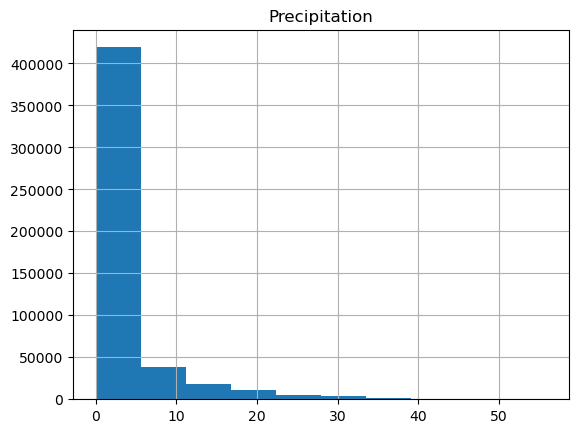

In [49]:
# histogram
weather_df.hist(column='Precipitation')

array([[<AxesSubplot: title={'center': 'TempMax'}>]], dtype=object)

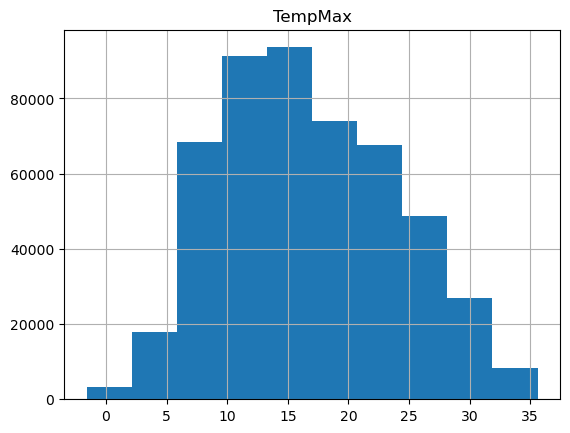

In [50]:
# histogram
weather_df.hist(column='TempMax')

array([[<AxesSubplot: title={'center': 'TempMin'}>]], dtype=object)

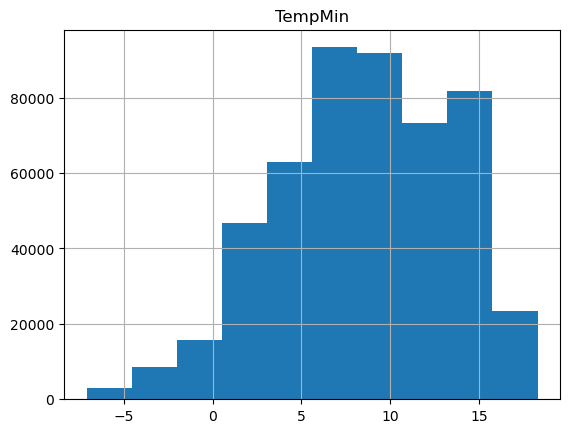

In [51]:
# histogram
weather_df.hist(column='TempMin')

array([[<AxesSubplot: title={'center': 'Wind'}>]], dtype=object)

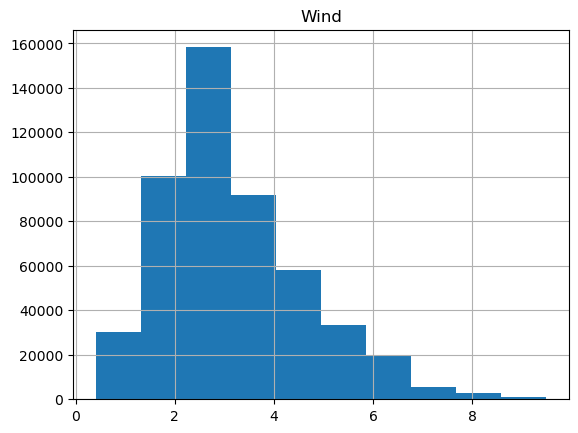

In [52]:
# histogram
weather_df.hist(column='Wind')

In [53]:
# categoricalize the numeric data 
# first make a copy
w_df = weather_df.copy()

# ranking
# because dataset contain lots of zero value, that make the pd.qcut not working well, as well as many dupulicate values
# choose rank method will assign a unique value to each element in the dataframe (the rank) while keeping the order of the elements (except for identical values, which will be ranked in order they appear in the array)
# because I didn't modify the data, so 100,000 repeats will definitely have many duplicates
# with rank method, P and p is equally split in terms of the number of records 
# solutions: https://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges/40548606#40548606?newreg=8e1d4be7e5be44029eb2ebcae421a6ea

# drop precipitation for testing 
w_df["Precipitation_Tag"] = pd.qcut(w_df["Precipitation"].rank(method='first'), 2, labels=["P", "p"])

w_df["TempMax_Tag"] = pd.qcut(w_df["TempMax"].rank(method='first'), 2, labels=["T", "t"])

w_df["TempMin_Tag"] = pd.qcut(w_df["TempMin"].rank(method='first'), 2, labels=["M", "m"])

w_df["Wind_Tag"] = pd.qcut(w_df["Wind"].rank(method='first'), 2, labels=["W", "w"])

# new set
new_w = w_df[["Sequence_ID",
             "Test_Date",
             "Precipitation_Tag",
             "TempMax_Tag",
             "TempMin_Tag", 
             "Wind_Tag",
             "Weather"]]

new_w['Event_Pattern'] = new_w['Precipitation_Tag'].astype(str) + new_w['TempMax_Tag'].astype(str) + new_w['TempMin_Tag'].astype(str) + new_w['Wind_Tag'].astype(str)

In [54]:
# continue with two dataset 
# one with PCT
new_w_withPCT.head()

,Sequence_ID,Test_Date,Precipitation_Tag,TempMax_Tag,TempMin_Tag,Wind_Tag,Weather,Event_Pattern
369,27,2013-01-25,p,t,M,W,rain,ptMW
370,27,2013-01-25,p,T,m,w,rain,pTmw
371,27,2013-01-25,p,t,M,W,rain,ptMW
372,27,2013-01-25,p,t,m,w,rain,ptmw
373,27,2013-01-25,p,t,m,W,rain,ptmW


In [55]:
# one without PCT
new_w.head()

,Sequence_ID,Test_Date,Precipitation_Tag,TempMax_Tag,TempMin_Tag,Wind_Tag,Weather,Event_Pattern
1276,71,2015-09-08,P,t,m,w,fog,Ptmw
1277,71,2015-09-08,P,t,m,w,sun,Ptmw
1278,71,2015-09-08,P,t,m,w,sun,Ptmw
1279,71,2015-09-08,P,t,m,W,sun,PtmW
1280,71,2015-09-08,P,t,m,W,sun,PtmW


### 4) Grouping Data

In [56]:
# grouping the data
# with PCT
pattern_withPCT = new_w_withPCT.groupby(['Sequence_ID', 
                                     'Test_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()
# without PCT
pattern_noPCT = new_w.groupby(['Sequence_ID', 
                                     'Test_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

In [57]:
pattern_withPCT

,Sequence_ID,Test_Date,Event_Pattern
0,10,2012-01-12,"{ptMw, PTMw, pTMW, Ptmw, PTMW, PTMw}"
1,10,2012-01-13,"{PTMw, pTMW, Ptmw, PTMW, PTMw, PTMw, pTMW, Ptm..."
2,10,2012-01-18,"{PTMW, PTMw, pTMW, ptMw, ptMw}"
3,10,2012-01-20,"{pTMW, ptMw, ptMw, pTMw}"
4,10,2012-01-22,"{pTMW, ptMw, ptMw, pTMw, PtMw, pTMW}"
...,...,...,...
39730,90,2015-12-19,"{PtMw, PtmW, ptmw, PTMW, PTMw, PTmw, pTmw, Ptm..."
39731,90,2015-12-21,"{PtMw, PtmW, ptmw, PTMW, PTMw, PTmw, pTmw, Ptm..."
39732,90,2015-12-23,"{PtMw, PtmW, ptmw, PTMW, PTMw, PTmw, pTmw, Ptm..."
39733,90,2015-12-24,"{PtmW, ptmw, PTMW, PTMw, PTmw, pTmw, Ptmw, PtM..."


In [58]:
# only keeping sun and rain weather in the dataset for now
# remove fog, drizzle, snow for now
sample_withPCT =  new_w_withPCT.loc[(new_w_withPCT['Weather'] == 'sun') | (new_w_withPCT['Weather'] == 'rain')]
sample_noPCT =  new_w.loc[(new_w['Weather'] == 'sun') | (new_w['Weather'] == 'rain')]

In [59]:
# dropping single-tag columns
sample_withPCT = sample_withPCT.drop(columns=['Precipitation_Tag', 'TempMax_Tag', 'TempMin_Tag', 'Wind_Tag', 'Event_Pattern'])
sample_noPCT = sample_noPCT.drop(columns=['Precipitation_Tag', 'TempMax_Tag', 'TempMin_Tag', 'Wind_Tag', 'Event_Pattern'])

In [60]:
# merging 
weather_withPCT = pd.merge(pattern_withPCT, sample_withPCT, on= ['Sequence_ID', 'Test_Date'], how='inner')
weather_noPCT = pd.merge(pattern_noPCT, sample_noPCT, on= ['Sequence_ID', 'Test_Date'], how='inner')

In [61]:
# eliminate the bracket event_pattern
# for sample withPCT
weather_withPCT['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in weather_withPCT['Event_Pattern'].values]
# for sample noPCT
weather_noPCT['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in weather_noPCT['Event_Pattern'].values]

In [62]:
weather_withPCT.head()

,Sequence_ID,Test_Date,Event_Pattern,Weather
0,10,2012-01-12,"ptMw,PTMw,pTMW,Ptmw,PTMW,PTMw",rain
1,10,2012-01-12,"ptMw,PTMw,pTMW,Ptmw,PTMW,PTMw",rain
2,10,2012-01-12,"ptMw,PTMw,pTMW,Ptmw,PTMW,PTMw",rain
3,10,2012-01-12,"ptMw,PTMw,pTMW,Ptmw,PTMW,PTMw",rain
4,10,2012-01-12,"ptMw,PTMw,pTMW,Ptmw,PTMW,PTMw",rain


In [63]:
# turn Test_Date into datetime type
weather_withPCT['Test_Date'] = pd.to_datetime(weather_withPCT['Test_Date'])
weather_noPCT['Test_Date'] = pd.to_datetime(weather_noPCT['Test_Date'])

# first date to 90 days before current date for test set 
train_withPCT = weather_withPCT[weather_withPCT['Test_Date'] < weather_withPCT.Test_Date.max() - dt.timedelta(days=90)]  
# use last x days of data for validation, test for volume first. Use last 90 days for validation
test_withPCT = weather_withPCT[weather_withPCT['Test_Date'] >= weather_withPCT.Test_Date.max() - dt.timedelta(days=90)] # current - 90 days: last 90 days

# for the noPCT
train_noPCT = weather_noPCT[weather_withPCT['Test_Date'] < weather_noPCT.Test_Date.max() - dt.timedelta(days=90)]  
test_noPCT = weather_noPCT[weather_withPCT['Test_Date'] >= weather_noPCT.Test_Date.max() - dt.timedelta(days=90)] # current - 90 days: last 90 days

In [64]:
test_withPCT

,Sequence_ID,Test_Date,Event_Pattern,Weather
1781,10,2015-10-03,PtMw,sun
1782,10,2015-10-10,"PtmW,ptmw",rain
1783,10,2015-10-12,"PtmW,ptmw,PTMW",rain
1784,10,2015-10-12,"PtmW,ptmw,PTMW",sun
1785,10,2015-10-17,"ptmw,PTMW,PTMw,PTmw",rain
...,...,...,...,...
903021,90,2015-12-31,"PtmW,ptmw,PTMW,PTMw,PTmw,pTmw,Ptmw,PtMW,pTmw,P...",rain
903022,90,2015-12-31,"PtmW,ptmw,PTMW,PTMw,PTmw,pTmw,Ptmw,PtMW,pTmw,P...",rain
903023,90,2015-12-31,"PtmW,ptmw,PTMW,PTMw,PTmw,pTmw,Ptmw,PtMW,pTmw,P...",rain
903024,90,2015-12-31,"PtmW,ptmw,PTMW,PTMw,PTmw,pTmw,Ptmw,PtMW,pTmw,P...",sun


In [65]:
# drop Test_Date attribute
train_withPCT = train_withPCT.drop(columns=['Test_Date'])
test_withPCT = test_withPCT.drop(columns=['Test_Date'])

train_noPCT = train_noPCT.drop(columns=['Test_Date'])
test_noPCT= test_noPCT.drop(columns=['Test_Date'])

In [66]:
# find unique pattern, same as saying collecting all pattern into a set (not duplicate pattern)
flat_list = [item.split(',') for item in train_withPCT['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

16

In [67]:
# create one dataset for sun and one for rain separately
sun_withPCT = train_withPCT[train_withPCT['Weather']=='sun'][['Sequence_ID', 'Event_Pattern']]
print(sun_withPCT.shape)
rain_withPCT = train_withPCT[train_withPCT['Weather']=='rain'][['Sequence_ID', 'Event_Pattern']]
print(rain_withPCT.shape)

#
sun_noPCT = train_noPCT[train_noPCT['Weather']=='sun'][['Sequence_ID', 'Event_Pattern']]
print(sun_noPCT.shape)
rain_noPCT = train_noPCT[train_noPCT['Weather']=='rain'][['Sequence_ID', 'Event_Pattern']]
print(rain_noPCT.shape)

(213836, 2)
(625576, 2)
(205938, 2)
(199827, 2)


In [68]:
# a first-ordered matrix will be built, meaning row attributes will follow the same order as the order of the column attributes
sun_grid_withPCT = build_transition_grid(sun_withPCT, unique_patterns) 
rain_grid_withPCT = build_transition_grid(rain_withPCT, unique_patterns) 

sun_grid_noPCT = build_transition_grid(sun_noPCT, unique_patterns) 
rain_grid_noPCT = build_transition_grid(rain_noPCT, unique_patterns) 

In [69]:
sun_grid_noPCT

,PTMW,PTMw,PTmW,PTmw,PtMW,PtMw,PtmW,Ptmw,pTMW,pTMw,pTmW,pTmw,ptMW,ptMw,ptmW,ptmw
x,,,,,,,,,,,,,,,,
PTMW,0.346284,0.205005,0.203110,0.000000,0.094645,0.082107,0.004209,0.000037,0.209165,0.089954,0.035462,0.047694,0.122798,0.004282,0.015420,0.000000
PTMw,0.157050,0.281990,0.000000,0.000000,0.103455,0.047172,0.000019,0.000044,0.063010,0.091692,0.000000,0.000005,0.000000,0.000000,0.000764,0.000062
PTmW,0.009802,0.000000,0.134434,0.000000,0.014792,0.000000,0.005745,0.004126,0.000000,0.000000,0.000000,0.030140,0.000000,0.000000,0.000000,0.003498
PTmw,0.016034,0.001421,0.000000,0.093702,0.000000,0.000425,0.005644,0.003101,0.018272,0.002982,0.000000,0.023039,0.000263,0.000000,0.006813,0.000000
PtMW,0.009378,0.014648,0.000000,0.122295,0.217407,0.218080,0.018686,0.015024,0.023093,0.030895,0.139285,0.064643,0.072153,0.124474,0.016194,0.000000
PtMw,0.014913,0.000079,0.095032,0.000000,0.206824,0.282338,0.008914,0.023118,0.000792,0.014261,0.003488,0.000000,0.000000,0.008517,0.000107,0.006075
PtmW,0.013333,0.000087,0.567905,0.177426,0.036252,0.031836,0.422628,0.440803,0.000139,0.015971,0.165918,0.016908,0.001763,0.027620,0.202319,0.216061
Ptmw,0.000248,0.014373,0.000000,0.000724,0.044309,0.136051,0.341587,0.382101,0.006130,0.001369,0.030767,0.023402,0.052717,0.000000,0.085440,0.112207
pTMW,0.184132,0.127753,0.000000,0.012241,0.048470,0.018912,0.000098,0.000000,0.257551,0.205339,0.060348,0.140221,0.157409,0.055287,0.013294,0.000101


### with PCT

In [70]:
# prediction on the training dataset
actual = []
predicted = []

temp_id = 12345
# outter loop start: a sequence for validation {"HMM", "LHL", "MLM", "HHH", "LLL"}
for seq_id in volume_test_set['Sequence_ID'].values:
    if temp_id != seq_id:
        count = 0
    temp_id = seq_id

    patterns = volume_test_set[volume_test_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[count].split(',')
    pos = []
    neg = []
    log_odds = []
    
    # inner loop start: calculating the patterns from one to one, and reach the end 
    for id in range(0, len(patterns)-1):
#         print(f"this is the {count} time")
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        
        # check if the first pair is both in pos and neg matrix
        if (patterns[id] in list(volume_grid_pos) and patterns[id+1] in list(volume_grid_pos) and patterns[id] in list(volume_grid_neg) and patterns[id+1] in list(volume_grid_neg)):
                
            # if they are in, build the probability of the pair: positive as numerator, negative as denominator
            numerator = volume_grid_pos[patterns[id]][patterns[id+1]]
            denominator = volume_grid_neg[patterns[id]][patterns[id+1]]
            
            # if they both == 0, meaning this patterns doesn't contain in the pre-built matrix, so the log value = 0
            if (numerator == 0 and denominator == 0):
                log_value =0
            
            # if negative matrix == 0, means the patterns doesn't exist in the neg matrix, 
            # we perform calculation on the positive one
            elif (denominator == 0):
                
                # why do we need log calculation? because when we keep times the coming value from the matrix without any modification,
                # we will result in very small probability for any event given a relatively long sequences of pattern, if that's the true possibility, then it's not practical in real life,
                # on the other hand, large number will require more calculation power, we want to reduce that
                # divided by 0.000001 is just make this log value into positive
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                
                # 0.000001 divide denominator is just make the log value into negative 
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0

        
        # append all log values, because we want to see it's either positive or negative it's enough
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
        # inner loop ends

    actual.append(volume_test_set[volume_test_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    predicted.append(sum(log_odds))
    # outter loop end
    count += 1

In [71]:
# turn sun into 1, rain into 0
for i in range(len(actual)):
    if actual[i] == "sun":
        actual[i] = 1
    else:
        actual[i]=0

# ===============================================
from sklearn.metrics import confusion_matrix
confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

array([[1253,  308],
       [   0,    0]])

In [72]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%') 

Accuracy: 80.27 %


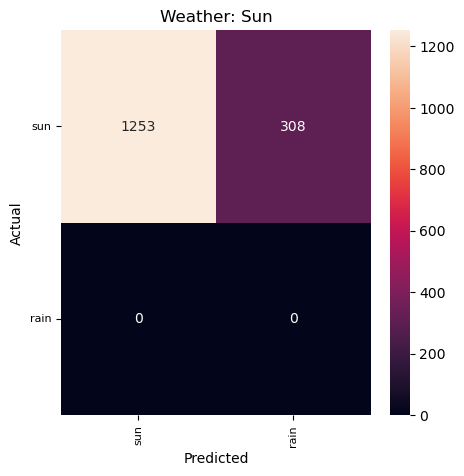

In [73]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Weather: Sun') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['sun','rain'])
ax.yaxis.set_ticklabels(['sun','rain'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

### without PCT

In [74]:
# prediction on the training dataset
actual = []
predicted = []

temp_id = 12345
# outter loop start: a sequence for validation {"HMM", "LHL", "MLM", "HHH", "LLL"}
for seq_id in volume_test_set['Sequence_ID'].values:
    if temp_id != seq_id:
        count = 0
    temp_id = seq_id

    patterns = volume_test_set[volume_test_set['Sequence_ID'] == seq_id]['Event_Pattern'].values[count].split(',')
    pos = []
    neg = []
    log_odds = []
    
    # inner loop start: calculating the patterns from one to one, and reach the end 
    for id in range(0, len(patterns)-1):
#         print(f"this is the {count} time")
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        
        # check if the first pair is both in pos and neg matrix
        if (patterns[id] in list(volume_grid_pos) and patterns[id+1] in list(volume_grid_pos) and patterns[id] in list(volume_grid_neg) and patterns[id+1] in list(volume_grid_neg)):
                
            # if they are in, build the probability of the pair: positive as numerator, negative as denominator
            numerator = volume_grid_pos[patterns[id]][patterns[id+1]]
            denominator = volume_grid_neg[patterns[id]][patterns[id+1]]
            
            # if they both == 0, meaning this patterns doesn't contain in the pre-built matrix, so the log value = 0
            if (numerator == 0 and denominator == 0):
                log_value =0
            
            # if negative matrix == 0, means the patterns doesn't exist in the neg matrix, 
            # we perform calculation on the positive one
            elif (denominator == 0):
                
                # why do we need log calculation? because when we keep times the coming value from the matrix without any modification,
                # we will result in very small probability for any event given a relatively long sequences of pattern, if that's the true possibility, then it's not practical in real life,
                # on the other hand, large number will require more calculation power, we want to reduce that
                # divided by 0.000001 is just make this log value into positive
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                
                # 0.000001 divide denominator is just make the log value into negative 
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0

        
        # append all log values, because we want to see it's either positive or negative it's enough
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
        # inner loop ends

    actual.append(volume_test_set[volume_test_set['Sequence_ID']==seq_id]['Next_Day_Volume_Outcome'].values[0])
    predicted.append(sum(log_odds))
    # outter loop end
    count += 1

In [75]:
# turn sun into 1, rain into 0
for i in range(len(actual)):
    if actual[i] == "sun":
        actual[i] = 1
    else:
        actual[i]=0

# ===============================================
from sklearn.metrics import confusion_matrix
confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])

array([[1253,  308],
       [   0,    0]])

In [76]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%') 

Accuracy: 80.27 %


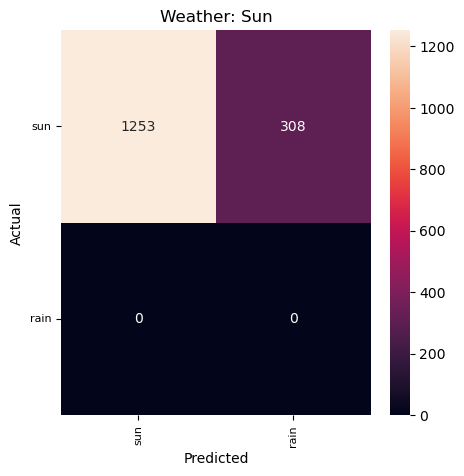

In [77]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Weather: Sun') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['sun','rain'])
ax.yaxis.set_ticklabels(['sun','rain'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()

# Volume | Return | Sun With PCT | Sun Without PCT

## epoch 1: 80.11 | 33.27 | 50.33 | 54.76 => start with randomized sample range 90 for Stock data and 30 for Weather data

## epoch 2: 78.08 | 46.21 | 50.89 | 56.23

## epoch 3: 68.09 | 48.64 | 50.9 | 55.97

## epoch 4: 74.79 | 53.87 | 50.56 | 46.75

## epoch 5: 78.57 | 55.42 | 68.27 | 62.26 => with randomized sample size increase range from 30 to 90 for Weather data

## epoch 6: 80.83 | 40.08 | 61.57 | 57.66

## epoch 7: 81.87 | 49.29 | 64.01 | 64.39

## epoch 8: 78.58 | 49.21 | 58.8 | 47,46

## epoch 9: 57.5 | 39.16 | 72.67 | 58.53

## epoch 10: 61.03 | 49.44 | 63.78 | 44.62

## epoch 11: 50.1 | 27.76 | 51.07 | 43.17=> both increase randomized sample range to 150

## epoch 12: 69.18 | 30.31 | 52.33 | 60.42

## epoch 13: 67.79 | 31.31 | 49.89 | 53.11

## epoch 14: 71.33 | 42.41 | 50.53 | 60.56 => stock data decrease range to 80 

## epoch 15: 81.1 | 51.6 | 48.61 | 55.82

## epoch 16: 74.49 | 56.6 | 61.16 | 49.04

## epoch 17: 79.9 | 51.66 | 69.15 | 51.12

## epoch 18: 75.21 | 28.34 | 64.59 | 52.75

## epoch 19: 80.79 | 49.9 | 68 | 52.31

## epoch 20: 75.4 | 47.52 | 61.25 | 50.89

In [78]:
#
# e = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
v_list = [80.11, 78.08, 68.09, 74.79, 78.57, 80.83, 81.87, 78.58, 57.5, 61.03, 50.1, 69.18, 67.79, 71.33, 81.1, 74.49, 79.9, 75.21, 80.79, 75.4]
r_list = [33.27, 46.21, 48.64, 53.87, 55.42, 40.08, 49.29, 49.21, 39.16, 49.44, 27.76, 30.31, 31.31, 42.41, 51.6, 56.6, 51.66, 28.34, 49.9, 47.52]
s_w = [50.33, 50.89, 50.9, 50.56, 68.27, 61.57, 64.01, 58.8, 72.67, 63.78, 51.07, 52.33, 49.89, 50.53, 48.61, 61.16, 69.15, 64.59, 68, 61.25]
s_n = [54.76, 56.23, 55.97, 46.75, 62.26, 57.66, 64.39, 47.46, 58.53, 44.62, 43.17, 60.42, 53.11, 60.56, 55.82, 49.04, 51.12, 52.75, 52.31, 50.89]

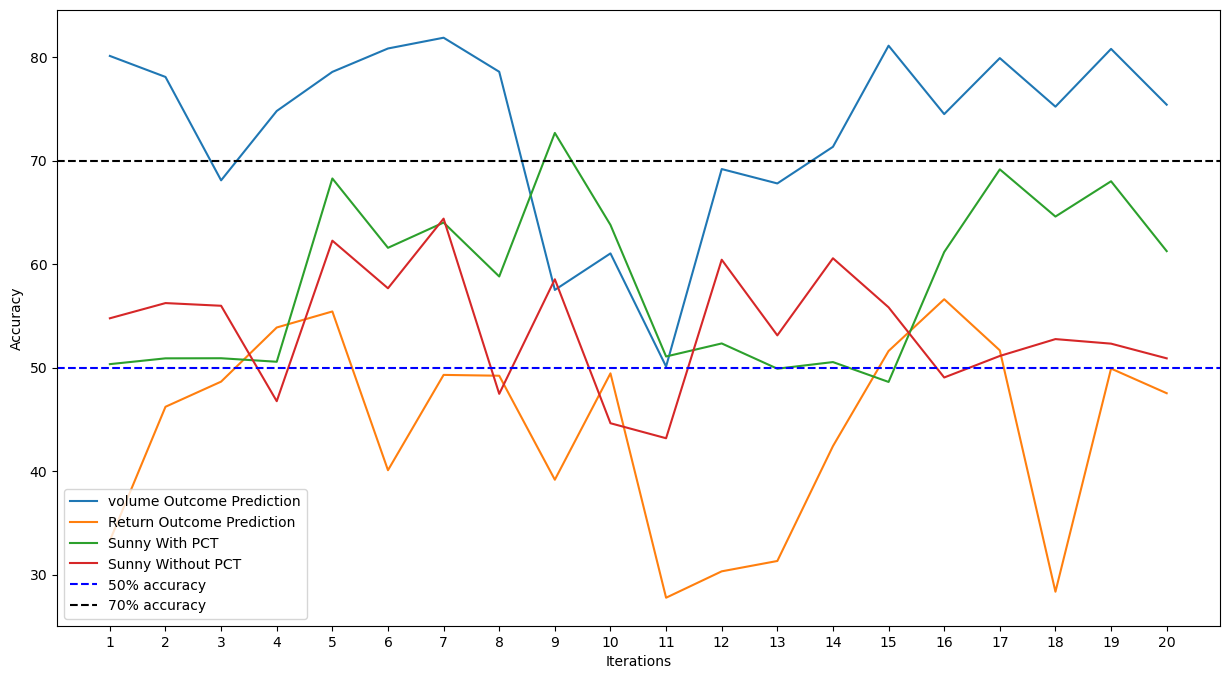

In [79]:
x = np.arange(1, 21, 1)
y  = v_list

plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, 21, 1.0))
plt.plot(x, v_list, label="volume Outcome Prediction")
plt.plot(x, r_list, label="Return Outcome Prediction")
plt.plot(x, s_w, label="Sunny With PCT")
plt.plot(x, s_n, label="Sunny Without PCT")
plt.axhline(y = 50, color = 'b', linestyle = '--', label = "50% accuracy")
plt.axhline(y = 70, color = 'black', linestyle = '--', label = "70% accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()

plt.show()